#Technical Indicator based Trading Strategies

In [31]:
!pip install yfinance
!pip install yahoofinancials
!pip install ta

In [32]:
# display multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [33]:
import pandas as pd
import numpy as np
import yfinance as yf

In [34]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 8)
plt.rcParams["lines.linewidth"] = 3.0

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-12-31,460.382172,461.757629,453.111938,454.733002,449.019958,19091
2011-01-03,454.978638,463.575195,454.782135,462.150604,456.344452,12076
2011-01-04,466.669952,469.519073,456.108459,459.989197,454.210144,12567


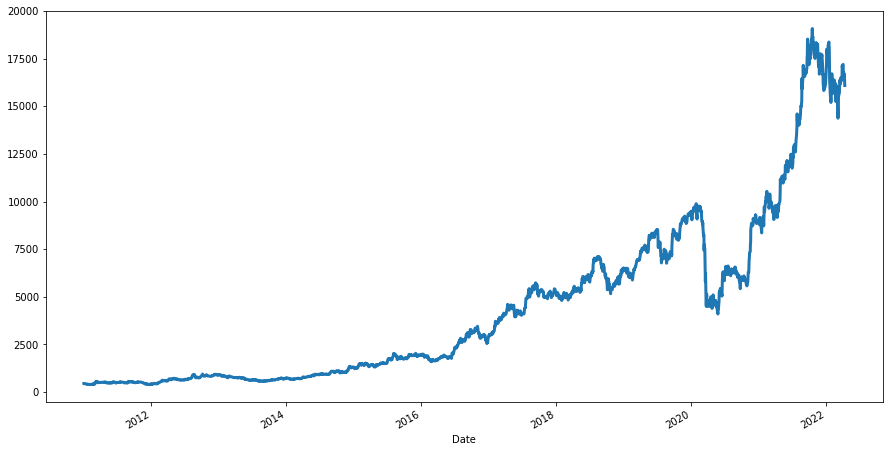

In [35]:
bajajdf = yf.download("BAJAJFINSV.NS", start="2010-12-31", progress=False)
bajajdf.head(3)
print()
bajajdf["Adj Close"].plot()

In [36]:
tilist, bestnarlist, bestsrlist = [], [], []

#Simple Moving Average

In [37]:
from ta.trend import SMAIndicator
bajajdf["sma20"] = SMAIndicator(close=bajajdf["Adj Close"], window=20, fillna=True).sma_indicator()
bajajdf["sma50"] = SMAIndicator(close=bajajdf["Adj Close"], window=50, fillna=True).sma_indicator()
bajajdf["signal"] = np.where(bajajdf["sma20"]>bajajdf["sma50"], 1, 0)
bajajdf["signal"] = bajajdf["signal"].shift(1)
bajajdf.dropna(inplace=True)
bajajdf["signal"].describe()

count    2781.000000
mean        0.636821
std         0.481002
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: signal, dtype: float64

In [38]:
bajajdf["ROC"] = np.log(bajajdf["Adj Close"] / bajajdf["Adj Close"].shift(1))
bajajdf["return"] = bajajdf["ROC"]*bajajdf["signal"]
bajajdf["portfolio"] = np.exp(bajajdf["return"].cumsum())
bajajdf.dropna(inplace=True)
bajajdf.tail(3)

,Open,High,Low,Close,Adj Close,Volume,sma20,sma50,signal,ROC,return,portfolio
Date,,,,,,,,,,,,
2022-04-11,16675.0,16845.449219,16550.050781,16577.849609,16577.849609,169686,16532.147266,16101.811895,1.0,-0.010271,-0.010271,19.504096
2022-04-12,16502.0,16502.000000,16222.099609,16318.049805,16318.049805,247647,16564.124756,16124.197891,1.0,-0.015796,-0.015796,19.198437
2022-04-13,16404.0,16500.000000,16050.000000,16090.049805,16090.049805,248390,16583.182227,16132.207891,1.0,-0.014071,-0.014071,18.930192


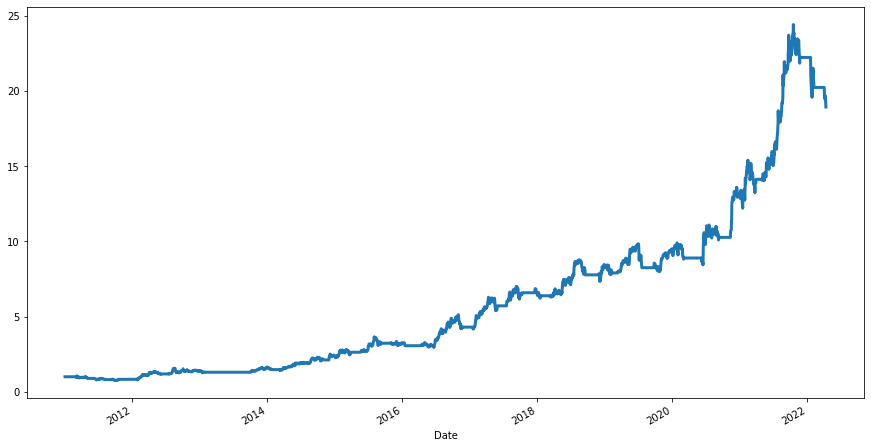

In [39]:
bajajdf["portfolio"].plot()

In [40]:
duration_days = bajajdf.index.max()-bajajdf.index.min()
duration_years = duration_days.days/365.25
duration_in_trade = duration_years * bajajdf["signal"].mean()
print(f"duration in trade: {duration_in_trade:.4f}")

net_avg_return = bajajdf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
print(f"net average return: {net_avg_return:.4f}")

returns = bajajdf[bajajdf["return"]!=0]["return"]
sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))
print(f"sharpe ratio: {sharpe_ratio:.4f}")

duration in trade: 7.1807
net average return: 0.5061
sharpe ratio: 1.1796


In [41]:
from ta.trend import SMAIndicator
import copy

iilist = []
jjlist = []
narlist = []
srlist = []

df = yf.download("BAJAJFINSV.NS", start="2010-12-31", progress=False)

for ii in range(10, 295, 5):
  for jj in range(ii+5, 300, 5):
    bajajdf = copy.deepcopy(df)
    bajajdf["sma1"] = SMAIndicator(close=bajajdf["Adj Close"], window=ii, fillna=True).sma_indicator()
    bajajdf["sma2"] = SMAIndicator(close=bajajdf["Adj Close"], window=jj, fillna=True).sma_indicator()
    bajajdf["signal"] = np.where(bajajdf["sma1"]>bajajdf["sma2"], 1, 0)
    bajajdf["signal"] = bajajdf["signal"].shift(1)
    bajajdf.dropna(inplace=True)
    bajajdf["ROC"] = np.log(bajajdf["Adj Close"] / bajajdf["Adj Close"].shift(1))
    bajajdf["return"] = bajajdf["ROC"]*bajajdf["signal"]
    bajajdf["portfolio"] = np.exp(bajajdf["return"].cumsum())
    bajajdf.dropna(inplace=True)
    duration_days = bajajdf.index.max()-bajajdf.index.min()
    duration_years = duration_days.days/365.25
    duration_in_trade = duration_years * bajajdf["signal"].mean()

    if (duration_in_trade!=0):
      net_avg_return = bajajdf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
      returns = bajajdf[bajajdf["return"]!=0]["return"]
      sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

    iilist.append(ii)
    jjlist.append(jj)
    narlist.append(net_avg_return)
    srlist.append(sharpe_ratio)

In [42]:
# net average return based
print(f"sma1: {iilist[np.argmax(narlist)]}")
print(f"sma2: {jjlist[np.argmax(narlist)]}")
print(f"nar: {max(narlist)}")

# sharpe ratio based
print(f"sma1: {iilist[np.argmax(srlist)]}")
print(f"sma2: {jjlist[np.argmax(srlist)]}")
print(f"sr: {max(srlist)}")

# resultdf = pd.DataFrame(np.column_stack([iilist, jjlist, narlist, srlist]), columns=["sma1", "sma2", "nar", "sr"])
# resultdf[(resultdf["sma1"]==10) & (resultdf["sma2"]==20)]

tilist.append("sma")
bestnarlist.append(max(narlist))
bestsrlist.append(max(srlist))

sma1: 30
sma2: 40
nar: 0.6978472128460835
sma1: 30
sma2: 40
sr: 1.5761631883384806


In [43]:
# resultdf = pd.DataFrame(np.column_stack(["Technical Indicator", narlist, srlist]), columns=["sma", "nar", "sr"])

#Exponential Moving Average

In [44]:
from ta.trend import SMAIndicator, EMAIndicator
import copy

iilist = []
jjlist = []
narlist = []
srlist = []

df = yf.download("BAJAJFINSV.NS", start="2010-12-31", progress=False)

for ii in range(10, 295, 5):
  for jj in range(ii+5, 300, 5):
    bajajdf = copy.deepcopy(df)
    bajajdf["sma1"] = EMAIndicator(close=bajajdf["Adj Close"], window=ii, fillna=True).ema_indicator()
    bajajdf["sma2"] = EMAIndicator(close=bajajdf["Adj Close"], window=jj, fillna=True).ema_indicator()
    bajajdf["signal"] = np.where(bajajdf["sma1"]>bajajdf["sma2"], 1, 0)
    bajajdf["signal"] = bajajdf["signal"].shift(1)
    bajajdf.dropna(inplace=True)
    bajajdf["ROC"] = np.log(bajajdf["Adj Close"] / bajajdf["Adj Close"].shift(1))
    bajajdf["return"] = bajajdf["ROC"]*bajajdf["signal"]
    bajajdf["portfolio"] = np.exp(bajajdf["return"].cumsum())
    bajajdf.dropna(inplace=True)
    duration_days = bajajdf.index.max()-bajajdf.index.min()
    duration_years = duration_days.days/365.25
    duration_in_trade = duration_years * bajajdf["signal"].mean()

    if (duration_in_trade!=0):
      net_avg_return = bajajdf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
      returns = bajajdf[bajajdf["return"]!=0]["return"]
      sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

    iilist.append(ii)
    jjlist.append(jj)
    narlist.append(net_avg_return)
    srlist.append(sharpe_ratio)

In [45]:
# net average return based
print(f"sma1: {iilist[np.argmax(narlist)]}")
print(f"sma2: {jjlist[np.argmax(narlist)]}")
print(f"nar: {max(narlist)}")

# sharpe ratio based
print(f"sma1: {iilist[np.argmax(srlist)]}")
print(f"sma2: {jjlist[np.argmax(srlist)]}")
print(f"sr: {max(srlist)}")

# resultdf = pd.DataFrame(np.column_stack([iilist, jjlist, narlist, srlist]), columns=["sma1", "sma2", "nar", "sr"])
# resultdf[(resultdf["sma1"]==10) & (resultdf["sma2"]==20)]

tilist.append("ema")
bestnarlist.append(max(narlist))
bestsrlist.append(max(srlist))

sma1: 10
sma2: 20
nar: 0.5992919478835541
sma1: 10
sma2: 20
sr: 1.3346453391599846


#Moving Average Convergence Divergence

In [47]:
import copy

iilist = []
jjlist = []
kklist = []
narlist = []
srlist = []

df = yf.download("BAJAJFINSV.NS", start="2010-12-31", progress=False)

for ii in range(4, 40, 2):
  for jj in range(ii+8, 80, 2):
    for kk in range(3, 20, 1):
      bajajdf = copy.deepcopy(df)
      bajajdf["macd line"] = bajajdf["Adj Close"].ewm(span=ii).mean() - bajajdf["Adj Close"].ewm(span=jj).mean()
      bajajdf["signal line"] = bajajdf["macd line"].ewm(span=kk).mean()
      bajajdf["signal"] = np.where(bajajdf["macd line"]>=bajajdf["signal line"], 1, 0)
      bajajdf["signal"] = bajajdf["signal"].shift(1)
      bajajdf["ROC"] = np.log(bajajdf["Adj Close"] / bajajdf["Adj Close"].shift(1))
      bajajdf["return"] = bajajdf["ROC"]*bajajdf["signal"]
      bajajdf["portfolio"] = np.exp(bajajdf["return"].cumsum())
      bajajdf.dropna(inplace=True)
      duration_days = bajajdf.index.max()-bajajdf.index.min()
      duration_years = duration_days.days/365.25
      duration_in_trade = duration_years * bajajdf["signal"].mean()

      if (duration_in_trade!=0):
        net_avg_return = bajajdf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
        returns = bajajdf[bajajdf["return"]!=0]["return"]
        sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

      iilist.append(ii)
      jjlist.append(jj)
      kklist.append(kk)
      narlist.append(net_avg_return)
      srlist.append(sharpe_ratio)

In [48]:
# net average return based
print(f"nfast: {iilist[np.argmax(narlist)]}")
print(f"nslow: {jjlist[np.argmax(narlist)]}")
print(f"nsig: {kklist[np.argmax(narlist)]}")
print(f"nar: {max(narlist)}")

# sharpe ratio based
print(f"nfast: {iilist[np.argmax(srlist)]}")
print(f"nslow: {jjlist[np.argmax(srlist)]}")
print(f"nsig: {kklist[np.argmax(srlist)]}")
print(f"sr: {max(srlist)}")

# resultdf = pd.DataFrame(np.column_stack([iilist, jjlist, kklist, narlist, srlist]), columns=["nfast", "nslow", "nsig", "nar", "sr"])
# resultdf[(resultdf["nfast"]==36) & (resultdf["nslow"]==44) & (resultdf["nsig"]==8)]

tilist.append("macd")
bestnarlist.append(max(narlist))
bestsrlist.append(max(srlist))

nfast: 36
nslow: 44
nsig: 8
nar: 0.8190376173978591
nfast: 36
nslow: 44
nsig: 8
sr: 1.6783928054014097


#Bollinger Bands

In [49]:
import copy

iilist = []
jjlist = []
narlist = []
srlist = []

df = yf.download("BAJAJFINSV.NS", start="2010-12-31", progress=False)

for ii in range(2, 50):
  for jj in np.arange(0.5, 3, 0.1):
    bajajdf = copy.deepcopy(df)
    bajajdf["20EMA"] = bajajdf["Adj Close"].ewm(span=ii).mean()
    bajajdf["upper band"] = bajajdf["20EMA"] + jj*bajajdf["Adj Close"].rolling(window=20).std()
    bajajdf["lower band"] = bajajdf["20EMA"] - jj*bajajdf["Adj Close"].rolling(window=20).std()
    bajajdf.dropna(inplace=True)
    bajajdf["signal"] = np.where(bajajdf["Adj Close"]>bajajdf["upper band"], 0, 
                                np.where(bajajdf["Adj Close"]<bajajdf["lower band"], 1,
                                          np.nan))

    if (np.isnan(bajajdf["signal"][0])):
      bajajdf["signal"][0] = 0

    bajajdf.signal.fillna(method="ffill", inplace=True)
    bajajdf["signal"] = bajajdf["signal"].shift(1)
    bajajdf.dropna(inplace=True)
    bajajdf["ROC"] = np.log(bajajdf["Adj Close"] / bajajdf["Adj Close"].shift(1))
    bajajdf["return"] = bajajdf["ROC"]*bajajdf["signal"]
    bajajdf["portfolio"] = np.exp(bajajdf["return"].cumsum())
    bajajdf.dropna(inplace=True)
    duration_days = bajajdf.index.max()-bajajdf.index.min()
    duration_years = duration_days.days/365.25
    duration_in_trade = duration_years * bajajdf["signal"].mean()

    if (duration_in_trade!=0):
      net_avg_return = bajajdf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
      returns = bajajdf[bajajdf["return"]!=0]["return"]
      sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

    iilist.append(ii)
    jjlist.append(jj)
    kklist.append(kk)
    narlist.append(net_avg_return)
    srlist.append(sharpe_ratio)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
# net average return based
print(f"n_ema: {iilist[np.argmax(narlist)]}")
print(f"n_sigma: {jjlist[np.argmax(narlist)]:0.2f}")
print(f"nar: {max(narlist)}")

# sharpe ratio return based
print(f"n_ema: {iilist[np.argmax(srlist)]}")
print(f"n_sigma: {jjlist[np.argmax(srlist)]:0.2f}")
print(f"sr: {max(srlist)}")

# resultdf = pd.DataFrame(np.column_stack([iilist, jjlist, narlist, srlist]), columns=["n_ema", "n_sig", "nar", "sr"])
# resultdf[(resultdf["n_ema"]==49) & (resultdf["n_sig"]>2.89) & (resultdf["n_sig"]<2.91) | (resultdf["n_ema"]==11) & (resultdf["n_sig"]>2.69) & (resultdf["n_sig"]<2.71)]
# resultdf[(resultdf["n_ema"]==49) | (resultdf["n_ema"]==11)]

tilist.append("bbands")
bestnarlist.append(max(narlist))
bestsrlist.append(max(srlist))

n_ema: 49
n_sigma: 2.90
nar: 1.1331721167413047
n_ema: 11
n_sigma: 2.70
sr: 2.159256619288398


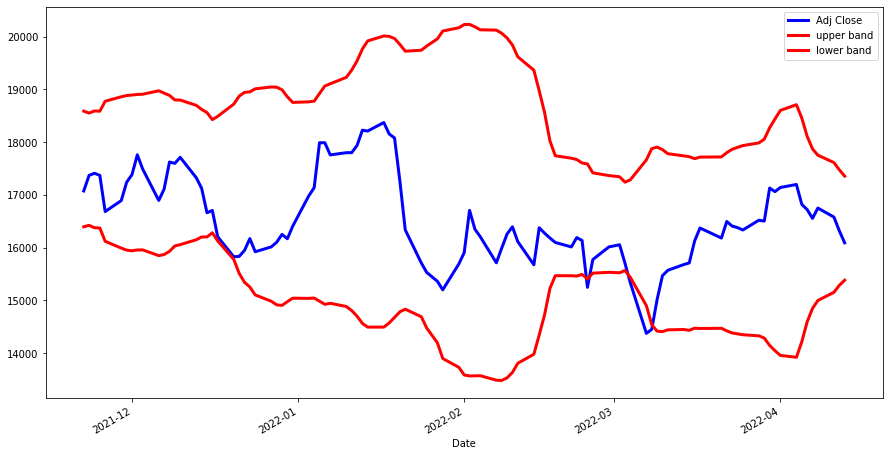

In [51]:
bajajdf[["Adj Close", "upper band", "lower band"]].tail(100).plot(color=('b','r','r'))

#Relative Strength Index

In [52]:
from ta.momentum import RSIIndicator
import copy

iilist = []
jjlist = []
kklist = []
narlist = []
srlist = []

df = yf.download("BAJAJFINSV.NS", start="2010-12-31", progress=False)

for ii in range(10, 50, 2):
  for jj in range(10, 40, 2):
    for kk in range(60, 90, 2):
      bajajdf = copy.deepcopy(df)
      bajajdf["rsi"] = RSIIndicator(close=bajajdf["Adj Close"], window=ii).rsi()
      bajajdf.dropna(inplace=True)
      bajajdf["signal"] = np.where(bajajdf["rsi"]<jj, 1,
                                  np.where(bajajdf["rsi"]>kk, 0,
                                            np.nan))
      if(np.isnan(bajajdf["signal"][0])):
        bajajdf["signal"][0] = 0

      bajajdf.signal.fillna(method='ffill', inplace=True)
      bajajdf["signal"] = bajajdf["signal"].shift(1)
      bajajdf.dropna(inplace=True)
      bajajdf["ROC"] = np.log(bajajdf["Adj Close"] / bajajdf["Adj Close"].shift(1))
      bajajdf["return"] = bajajdf["ROC"]*bajajdf["signal"]
      bajajdf["portfolio"] = np.exp(bajajdf["return"].cumsum())
      bajajdf.dropna(inplace=True)
      duration_days = bajajdf.index.max()-bajajdf.index.min()
      duration_years = duration_days.days/365.25
      duration_in_trade = duration_years * bajajdf["signal"].mean()

      if (duration_in_trade!=0):
        net_avg_return = bajajdf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
        returns = bajajdf[bajajdf["return"]!=0]["return"]
        sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

      iilist.append(ii)
      jjlist.append(jj)
      kklist.append(kk)
      narlist.append(net_avg_return)
      srlist.append(sharpe_ratio)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [53]:
# net average return based
print(f"n_window: {iilist[np.argmax(narlist)]}")
print(f"n_low: {jjlist[np.argmax(narlist)]}")
print(f"n_high: {kklist[np.argmax(narlist)]}")
print(f"nar: {max(narlist)}")

# sharpe ratio based
print(f"n_window: {iilist[np.argmax(srlist)]}")
print(f"n_low: {jjlist[np.argmax(srlist)]}")
print(f"n_high: {kklist[np.argmax(srlist)]}")
print(f"sr: {max(srlist)}")

# resultdf = pd.DataFrame(np.column_stack([iilist, jjlist, kklist, narlist, srlist]), columns=["n_window", "n_low", "n_high", "nar", "sr"])
# resultdf[(resultdf["n_window"]==10) & (resultdf["n_low"]==10) & (resultdf["n_high"]==84)]

tilist.append("rsi")
bestnarlist.append(max(narlist))
bestsrlist.append(max(srlist))

n_window: 10
n_low: 10
n_high: 84
nar: 5.725993688555751
n_window: 10
n_low: 10
n_high: 84
sr: 3.185664143140351


In [54]:
comparisondf = pd.DataFrame(np.column_stack([tilist, bestnarlist, bestsrlist]), columns=["Technical Indicator", "Best NAR", "Best SR"])
comparisondf

,Technical Indicator,Best NAR,Best SR
0,sma,0.6978472128460835,1.5761631883384806
1,ema,0.5992919478835541,1.3346453391599846
2,macd,0.8190376173978591,1.6783928054014097
3,bbands,1.1331721167413047,2.159256619288398
4,rsi,5.725993688555751,3.185664143140351
